In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u
import pkg_resources
from ruamel.yaml import YAML
import time 
from astropy.coordinates import Distance
from astropy.constants import k_B, m_e, c, G, M_sun
from agnpy.utils.plot import sed_x_label, sed_y_label, load_mpl_rc
# gammapy modules
from gammapy.modeling.models import (
    SpectralModel,
    Parameter,
    SPECTRAL_MODEL_REGISTRY,
    SkyModel,
)
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.modeling import Fit
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.emission_regions import Blob
from agnpy.targets import SSDisk, RingDustTorus
from sherpa import data
from sherpa.models import model
from ruamel.yaml import YAML
from astropy.table import Table
from astropy.coordinates import Distance
from gammapy.estimators import FluxPoints
import logging
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar
from gammapy.modeling.sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)
yaml = YAML()
from astropy.io import ascii
from astropy.table import Table 

from uncertainties.umath import *
from uncertainties import ufloat
from uncertainties import ufloat_fromstr

In [37]:
# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)

In [38]:
class AgnpyEC(SpectralModel):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    tag = "EC"
    log10_k_e = Parameter("log10_k_e", -5, min=-20, max=2)
    p1 = Parameter("p1", 2.1, min=1.0, max=5.0)
    p2 = Parameter("p2", 3.1, min=1.0, max=5.0)
    log10_gamma_b = Parameter("log10_gamma_b", 3, min=1, max=6)
    log10_gamma_min = Parameter("log10_gamma_min", 1, min=0, max=4)
    log10_gamma_max = Parameter("log10_gamma_max", 5, min=3, max=8)
    # source general parameters
    z = Parameter("z", 0.1, min=0.01, max=1)
    d_L = Parameter("d_L", "1e27 cm", min=1e25, max=1e33)
    # emission region parameters
    delta_D = Parameter("delta_D", 10, min=1, max=40)
    log10_B = Parameter("log10_B", 0.0, min=-3.0, max=1.0)
    t_var = Parameter("t_var", "600 s", min=10, max=np.pi * 1e7)
    mu_s = Parameter("mu_s", 0.9, min=0.0, max=1.0)
    log10_r = Parameter("log10_r", 17.0, min=16.0, max=20.0)
    # disk parameters
    log10_L_disk = Parameter("log10_L_disk", 45.0, min=42.0, max=48.0)
    log10_M_BH = Parameter("log10_M_BH", 42, min=32, max=45)
    m_dot = Parameter("m_dot", "1e26 g s-1", min=1e24, max=1e30)
    R_in = Parameter("R_in", "1e14 cm", min=1e12, max=1e16)
    R_out = Parameter("R_out", "1e17 cm", min=1e12, max=1e19)
    # DT parameters
    xi_dt = Parameter("xi_dt", 0.6, min=0.0, max=1.0)
    T_dt = Parameter("T_dt", "1e3 K", min=1e2, max=1e4)
    R_dt = Parameter("R_dt", "2.5e18 cm", min=1.0e17, max=1.0e19)

    @staticmethod
    def evaluate(
        energy,
        log10_k_e,
        p1,
        p2,
        log10_gamma_b,
        log10_gamma_min,
        log10_gamma_max,
        z,
        d_L,
        delta_D,
        log10_B,
        t_var,
        mu_s,
        log10_r,
        log10_L_disk,
        log10_M_BH,
        m_dot,
        R_in,
        R_out,
        xi_dt,
        T_dt,
        R_dt,
    ):
        # conversion
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = (c * t_var * delta_D / (1 + z)).to("cm")
        r = 10 ** log10_r * u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        nu = energy.to("Hz", equivalencies=u.spectral())

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            nu,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )

        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            nu, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            nu, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )

        sed = sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt

        return (sed / energy ** 2).to("1 / (cm2 eV s)")


SPECTRAL_MODEL_REGISTRY.append(AgnpyEC)

In [39]:
sed_path = '/home/pc/Desktop/PKS1510_modelling-main/data/data_mcmc/PKS1510-089_2015b.ecsv'
flux_points = FluxPoints.read(sed_path)

# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
x = flux_points.table["e_ref"]
y = flux_points.table["e2dnde"]
y_err_stat = flux_points.table["e2dnde_errn"]
y_err_syst = np.zeros(len(x))

# define energy ranges
e_vhe = 100 * u.GeV
e_he = 0.1 * u.GeV
e_x_ray_max = 300 * u.keV
e_x_ray_min = 0.3 * u.keV
vhe_gamma = x >= e_vhe
he_gamma = (x >= e_he) * (x < e_vhe)
x_ray = (x >= e_x_ray_min) * (x < e_x_ray_max)
uv_to_radio = x < e_x_ray_min

# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst

# sum in quadrature the errors
flux_points.table["e2dnde_err"] = np.sqrt(y_err_stat ** 2 + y_err_syst ** 2)
flux_points = flux_points.to_sed_type("dnde")

In [40]:
# declare a model
agnpy_ec = AgnpyEC()

# initialise parameters
z = 0.361
d_L = Distance(z=z).to("cm")

# - blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# - disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 10000 * R_g
# - DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3 * u.K
R_dt = 6.47 * 1e18 * u.cm
# - size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm

# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z.quantity = z
agnpy_ec.z.frozen = True
agnpy_ec.d_L.quantity = d_L.cgs.value
agnpy_ec.d_L.frozen = True
# -- SS disk
agnpy_ec.log10_L_disk.quantity = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.frozen = True
agnpy_ec.log10_M_BH.quantity = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.frozen = True
agnpy_ec.m_dot.quantity = m_dot
agnpy_ec.m_dot.frozen = True
agnpy_ec.R_in.quantity = R_in
agnpy_ec.R_in.frozen = True
agnpy_ec.R_out.quantity = R_out
agnpy_ec.R_out.frozen = True
# -- Dust Torus
agnpy_ec.xi_dt.quantity = xi_dt
agnpy_ec.xi_dt.frozen = True
agnpy_ec.T_dt.quantity = T_dt
agnpy_ec.T_dt.frozen = True
agnpy_ec.R_dt.quantity = R_dt
agnpy_ec.R_dt.frozen = True
# - blob parameters
agnpy_ec.delta_D.quantity = delta_D
agnpy_ec.delta_D.frozen = True
agnpy_ec.log10_B.quantity = np.log10(B.to_value("G"))
agnpy_ec.mu_s.quantity = mu_s
agnpy_ec.mu_s.frozen = True
agnpy_ec.t_var.quantity = t_var
agnpy_ec.t_var.frozen = True
agnpy_ec.log10_r.quantity = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.frozen = True
# - EED
agnpy_ec.log10_k_e.quantity = np.log10(0.15)
agnpy_ec.p1.quantity = 1.6
agnpy_ec.p2.quantity = 3.6
agnpy_ec.log10_gamma_b.quantity = np.log10(500)
agnpy_ec.log10_gamma_min.quantity = np.log10(1)
agnpy_ec.log10_gamma_min.frozen = True
agnpy_ec.log10_gamma_max.quantity = np.log10(3e4)
agnpy_ec.log10_gamma_max.frozen = True

/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy

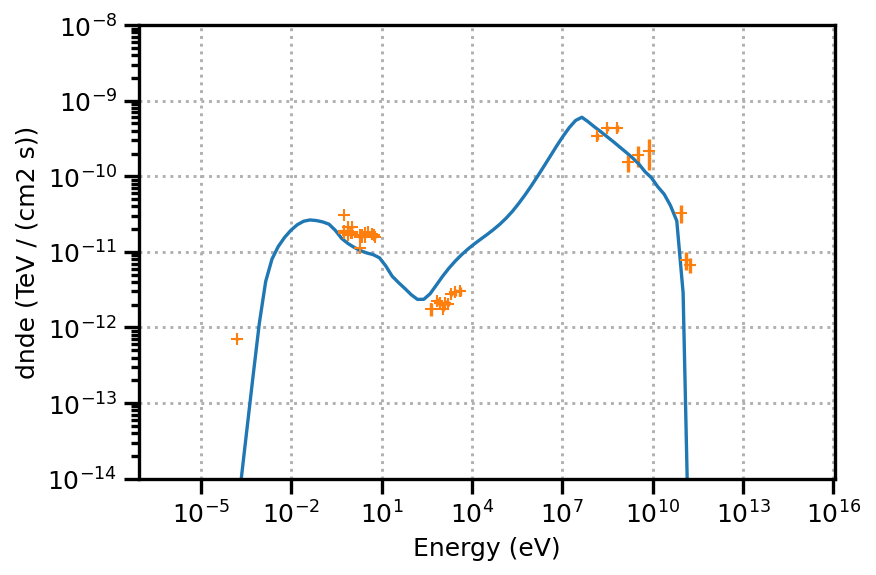

In [41]:
# plot initial model
agnpy_ec.plot(energy_range=[1e-6, 1e15] * u.eV, energy_unit="eV", energy_power=2)
flux_points.plot(energy_unit="eV", energy_power=2)
plt.ylim([1e-14, 1e-8])
plt.show()

In [42]:
# define model
model = SkyModel(name="PKS1510-089_EC", spectral_model=agnpy_ec)
dataset_ec = FluxPointsDataset(model, flux_points)
# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
dataset_ec.mask_fit = dataset_ec.data.energy_ref > E_min_fit

In [43]:
%%time
# define the fitter
fitter = Fit([dataset_ec])
results = fitter.run(optimize_opts={"print_level": 1})
print(results)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 230.5                      │        Nfcn = 578 (578 total)        │
│ EDM = 2.32e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 578
	total stat : 230.45

CPU times: user 5min, sys: 23.5 s, total: 5min 23s
Wall time: 5min 45s


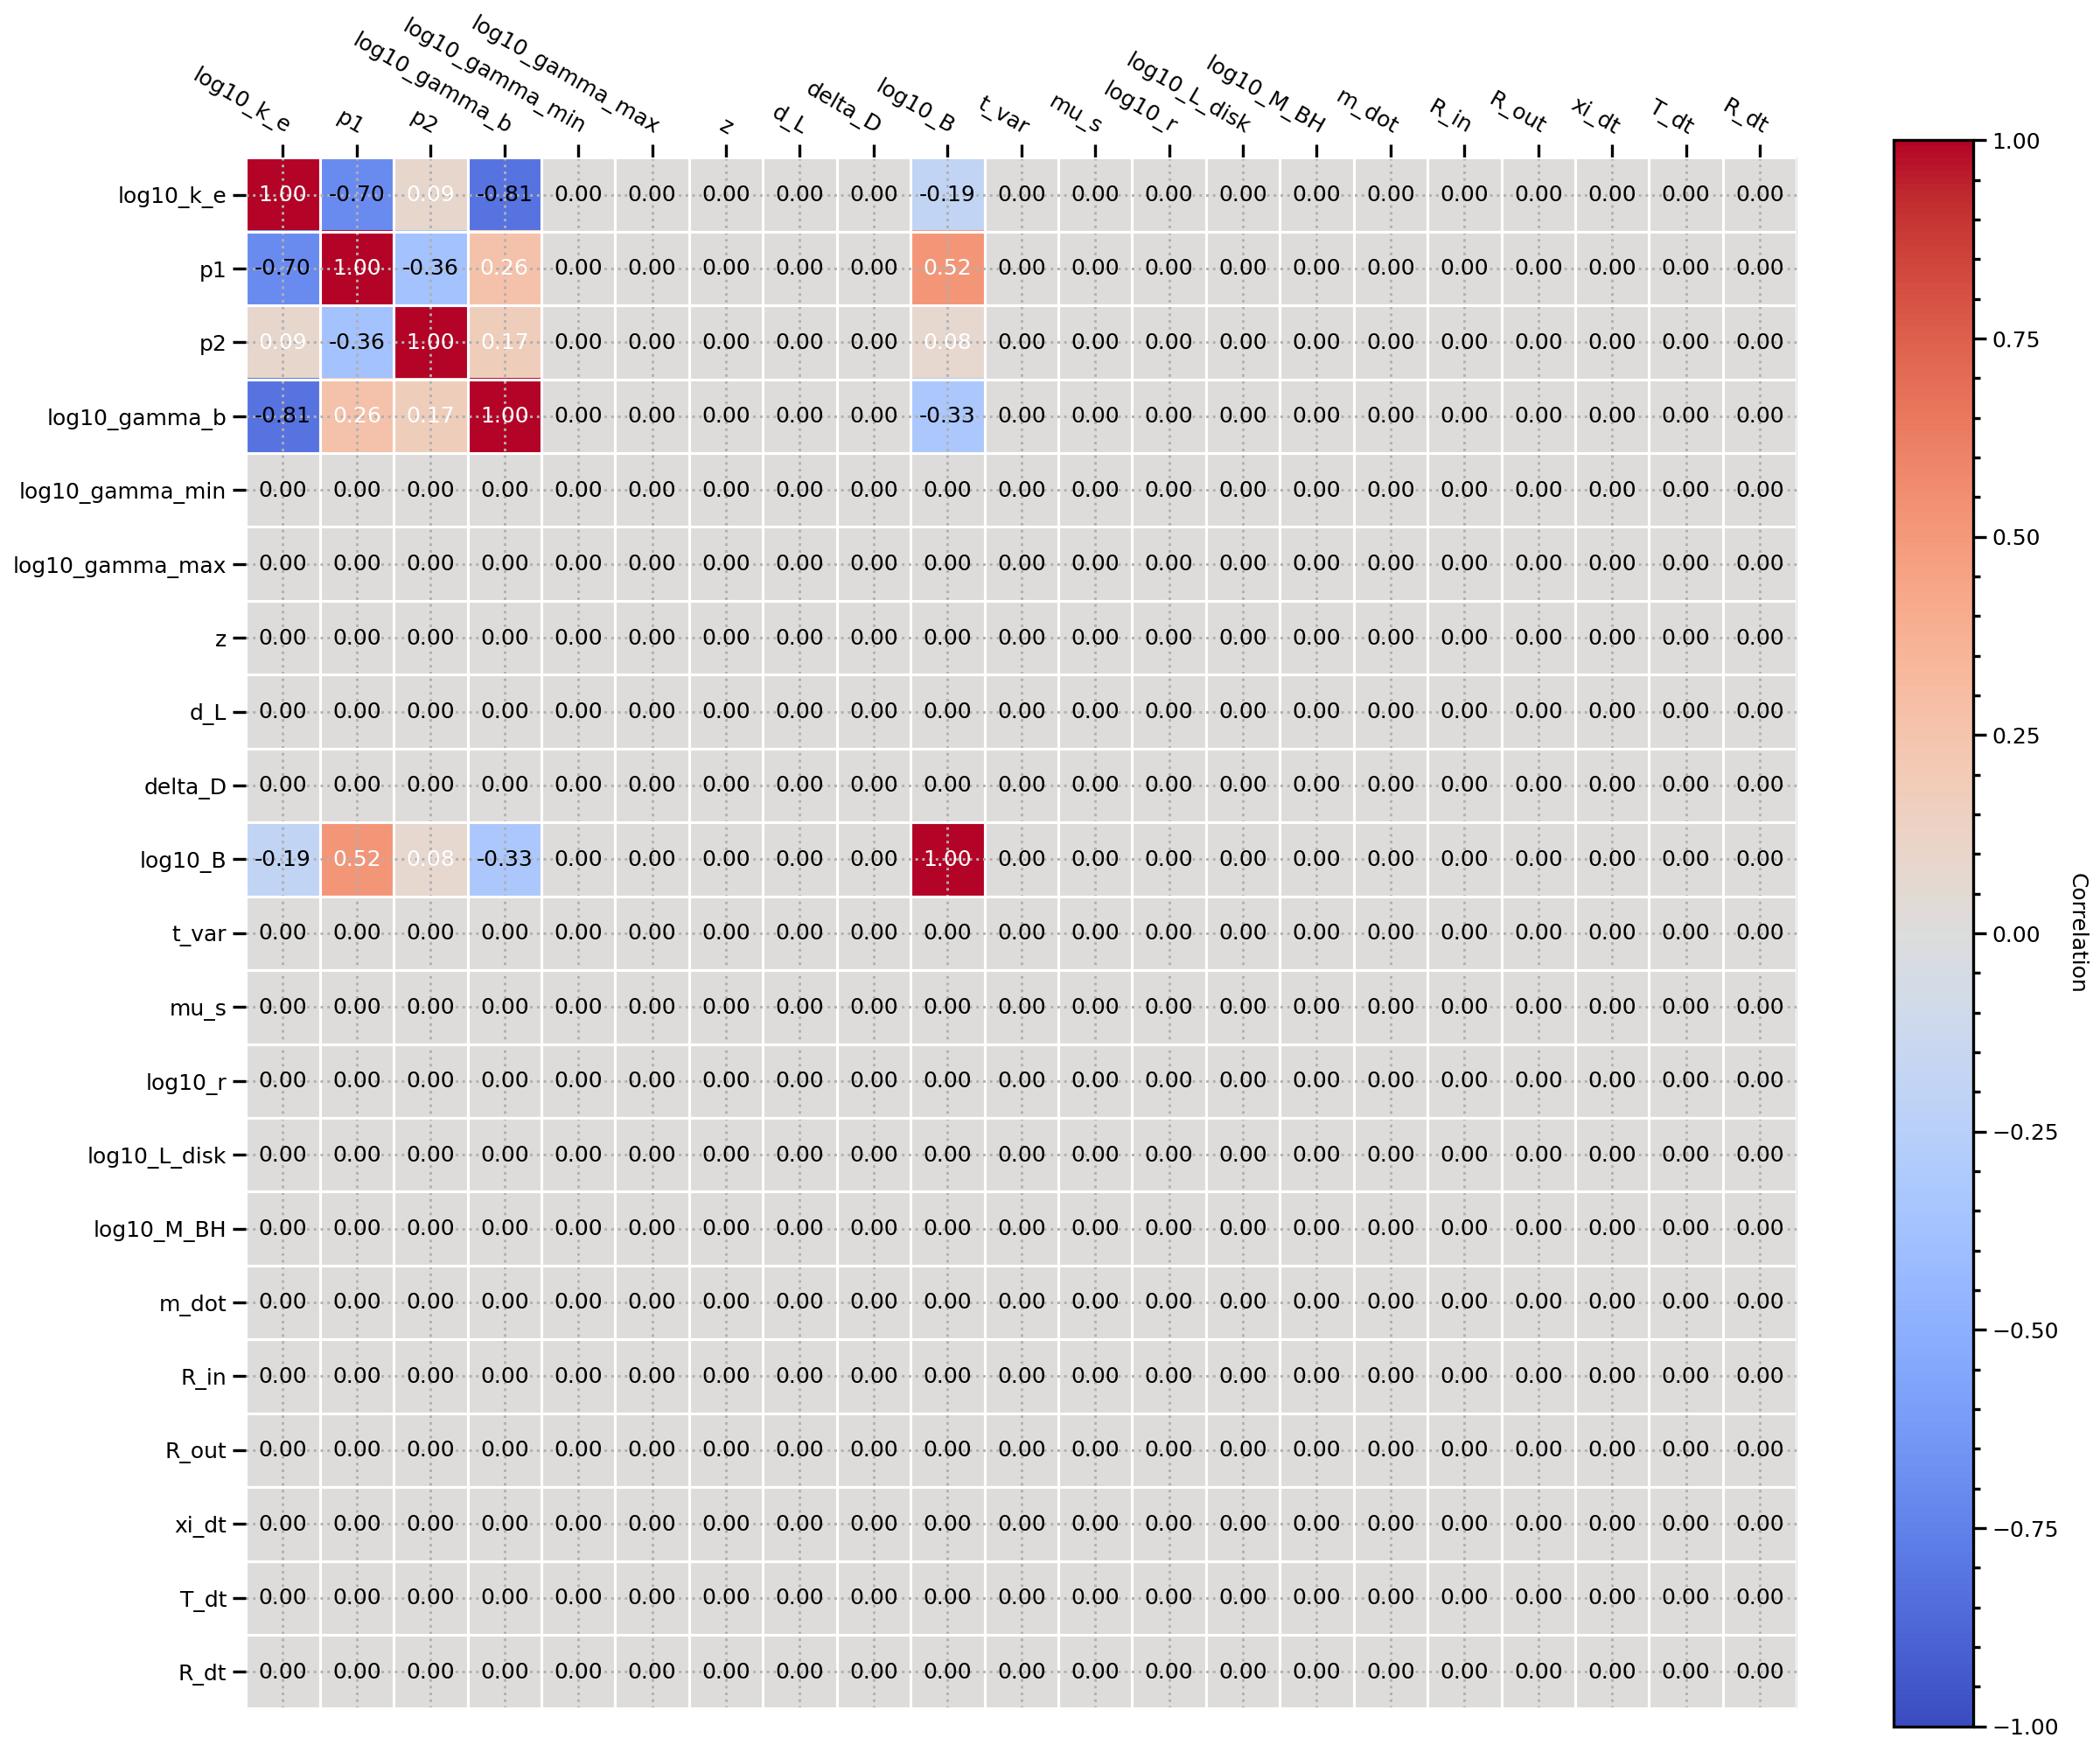

In [44]:
agnpy_ec.covariance.plot_correlation()
plt.show()

In [45]:
# define the emission region and the thermal emitters
k_e = 10 ** agnpy_ec.log10_k_e.value * u.Unit("cm-3")
p1 = agnpy_ec.p1.value
p2 = agnpy_ec.p2.value
gamma_b = 10 ** agnpy_ec.log10_gamma_b.value
gamma_min = 10 ** agnpy_ec.log10_gamma_min.value
gamma_max = 10 ** agnpy_ec.log10_gamma_max.value
B = 10 ** agnpy_ec.log10_B.value * u.G
r = 10 ** agnpy_ec.log10_r.value * u.cm
delta_D = agnpy_ec.delta_D.value
R_b = (
    c * agnpy_ec.t_var.quantity * agnpy_ec.delta_D.quantity / (1 + agnpy_ec.z.quantity)
).to("cm")
# blob definition
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(
    R_b,
    z,
    delta_D,
    Gamma,
    B,
    k_e,
    spectrum_dict,
    spectrum_norm_type="differential",
    gamma_size=500,
)
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

# Disk and DT definition
L_disk = 10 ** agnpy_ec.log10_L_disk.value * u.Unit("erg s-1")
M_BH = 10 ** agnpy_ec.log10_M_BH.value * u.Unit("g")
m_dot = agnpy_ec.m_dot.value * u.Unit("g s-1")
eta = (L_disk / (m_dot * c ** 2)).to_value("")
R_in = agnpy_ec.R_in.value * u.cm
R_out = agnpy_ec.R_out.value * u.cm
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
dt = RingDustTorus(L_disk, xi_dt, T_dt, R_dt=R_dt)
print(disk)
print(dt)

* spherical emission region
 - R_b (radius of the blob): 2.38e+16 cm
 - V_b (volume of the blob): 5.64e+49 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.50e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.22e+00 deg
 - B (magnetic field tangled to the jet): 3.79e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 8.74e-03 1 / cm3
 - p1: 2.00
 - p2: 3.16
 - gamma_b: 1.03e+03
 - gamma_min: 1.00e+00
 - gamma_max: 3.00e+04
jet power in particles: 2.52e+45 erg / s
jet power in B: 2.43e+44 erg / s
* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 1.14e+41 g
 - L_disk (disk luminosity): 6.70e+45 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 8.95e+25 g / s
 - R_in (disk inner radius): 5.06e+13 cm
 - R_out (disk inner radius): 8.43

In [46]:
"""
#convert results to file 
def write_parameters_to_yaml(agnpy_ec, path):
    write the model parameters in a yaml file
    parameters = dict()
    for par in agnpy_ec.pars:
        if par.name.startswith("log10_"):
            # store the power of 10 of logarithmic quantities
            # - strip the log10 prefix and elevate to the power of 10
            name = par.name.split("log10_")[1]
            parameters[name] = float(f"{10**par.val:.3e}")
        else:
            parameters[par.name] = float(f"{par.val:.3e}")
    print yaml.dump(parameters)

"""

'\n#convert results to file \ndef write_parameters_to_yaml(agnpy_ec, path):\n    write the model parameters in a yaml file\n    parameters = dict()\n    for par in agnpy_ec.pars:\n        if par.name.startswith("log10_"):\n            # store the power of 10 of logarithmic quantities\n            # - strip the log10 prefix and elevate to the power of 10\n            name = par.name.split("log10_")[1]\n            parameters[name] = float(f"{10**par.val:.3e}")\n        else:\n            parameters[par.name] = float(f"{par.val:.3e}")\n    print yaml.dump(parameters)\n\n'

In [47]:
#define the radiative processes
synch = Synchrotron(blob, ssa=True)
ssc = SynchrotronSelfCompton(blob, synch)
ec_dt = ExternalCompton(blob, dt, r)
# SEDs
nu = np.logspace(9, 27, 200) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
ec_dt_sed = ec_dt.sed_flux(nu)
disk_bb_sed = disk.sed_flux(nu, z)
dt_bb_sed = dt.sed_flux(nu, z)
total_sed = synch_sed + ssc_sed + ec_dt_sed + disk_bb_sed + dt_bb_sed

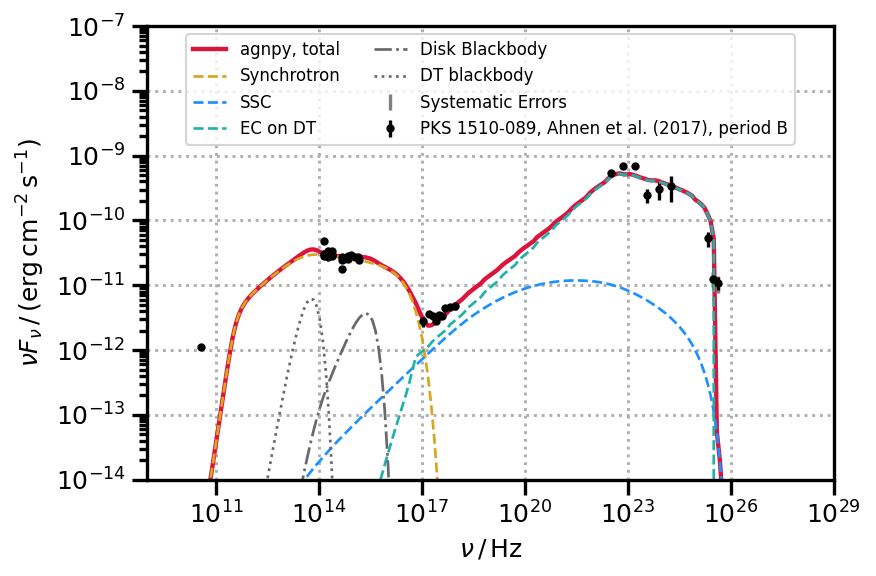

In [48]:
load_mpl_rc()

fig, ax = plt.subplots()
ax.loglog(
    nu / (1 + z), total_sed, ls="-", lw=2.1, color="crimson", label="agnpy, total"
    )
ax.loglog(
    nu / (1 + z),
    synch_sed,
    ls="--",
    lw=1.3,
    color="goldenrod",
    label="Synchrotron",
)
ax.loglog(nu / (1 + z), ssc_sed, ls="--", lw=1.3, color="dodgerblue", label="SSC")
ax.loglog(
    nu / (1 + z),
    ec_dt_sed,
    ls="--",
    lw=1.3,
    color="lightseagreen",
    label="EC on DT",
)
ax.loglog(
    nu / (1 + z),
    disk_bb_sed,
    ls="-.",
    lw=1.3,
    color="dimgray",
    label="Disk Blackbody",
)
ax.loglog(
    nu / (1 + z), dt_bb_sed, ls=":", lw=1.3, color="dimgray", label="DT blackbody",
)
# systematics error in gray
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_syst,
    marker=",",
    ls="",
    color="gray",
    label="Systematic Errors",
)
# statistics error in black
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_stat,
    marker=".",
    ls="",
    color="k",
    label="PKS 1510-089, Ahnen et al. (2017), period B",
)
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_xlim([1e9, 1e29])
ax.set_ylim([10 ** (-14), 10 ** (-7)])
ax.legend(
        loc="upper center", fontsize=8, ncol=2,
)

In [49]:
%%time
sampler = run_mcmc(dataset_ec, nwalkers=18, nrun=500)  # to speedup the notebook

CPU times: user 1h 11min 22s, sys: 4min 16s, total: 1h 15min 39s
Wall time: 1h 15min 42s


In [50]:
print (sampler, dataset_ec)


<emcee.ensemble.EnsembleSampler object at 0x7f432fc7cac0> FluxPointsDataset
-----------------

  Name                            : Gb7u1245 

  Number of total flux points     : 42 
  Number of fit bins              : 41 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 231.95

  Number of models                : 1 
  Number of parameters            : 21
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : PKS1510-089_EC
    Datasets names            : None
    Spectral model type       : AgnpyEC
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      log10_k_e               :  -1.919              
      p1                      :   1.981              
      p2                      :   3.131              
      log10_gamma_b            :   2.954              
      log10_gamma_min (frozen)   :   0.000              
      log10_gamma_max (frozen)   :   4.477              
      z    

In [51]:
k_e = 10 ** (-2.276) * u.Unit("cm-3")
print(k_e)
gamma_b = 10 ** 3.093
print (gamma_b)
gamma_max = 10 ** 4.477 
print (gamma_max)

B = (10 **-0.448)* u.G
print (B)

P_jet_mcmc =  2*np.pi*(R_b**2)*Beta*(Gamma**2)*3e8*(B**2)/8*np.pi
print (P_jet_mcmc)

0.005296634438916581 1 / cm3
1238.796586530369
29991.62518987653
0.35645113342624424 G
2.126425240695298e+43 cm2 G2


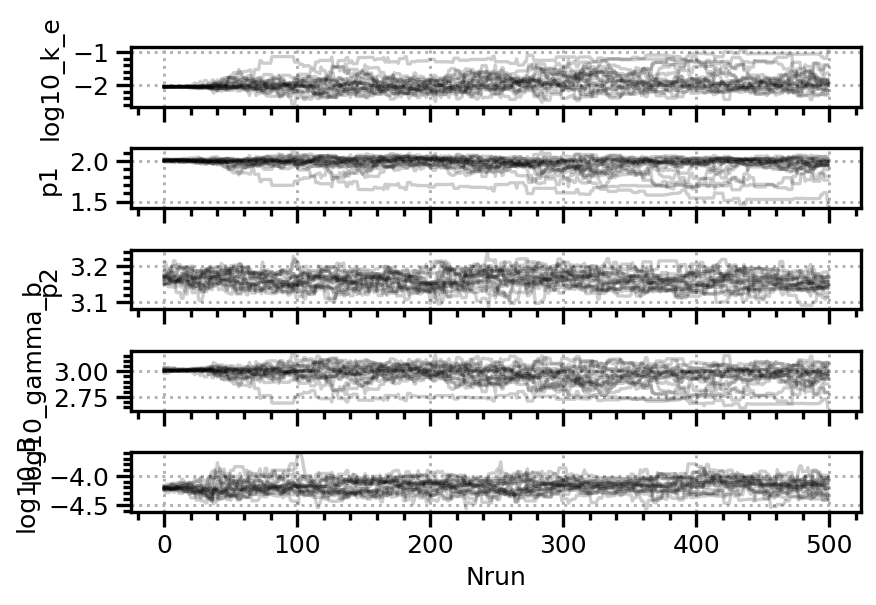

In [52]:
plot_trace(sampler, dataset_ec)

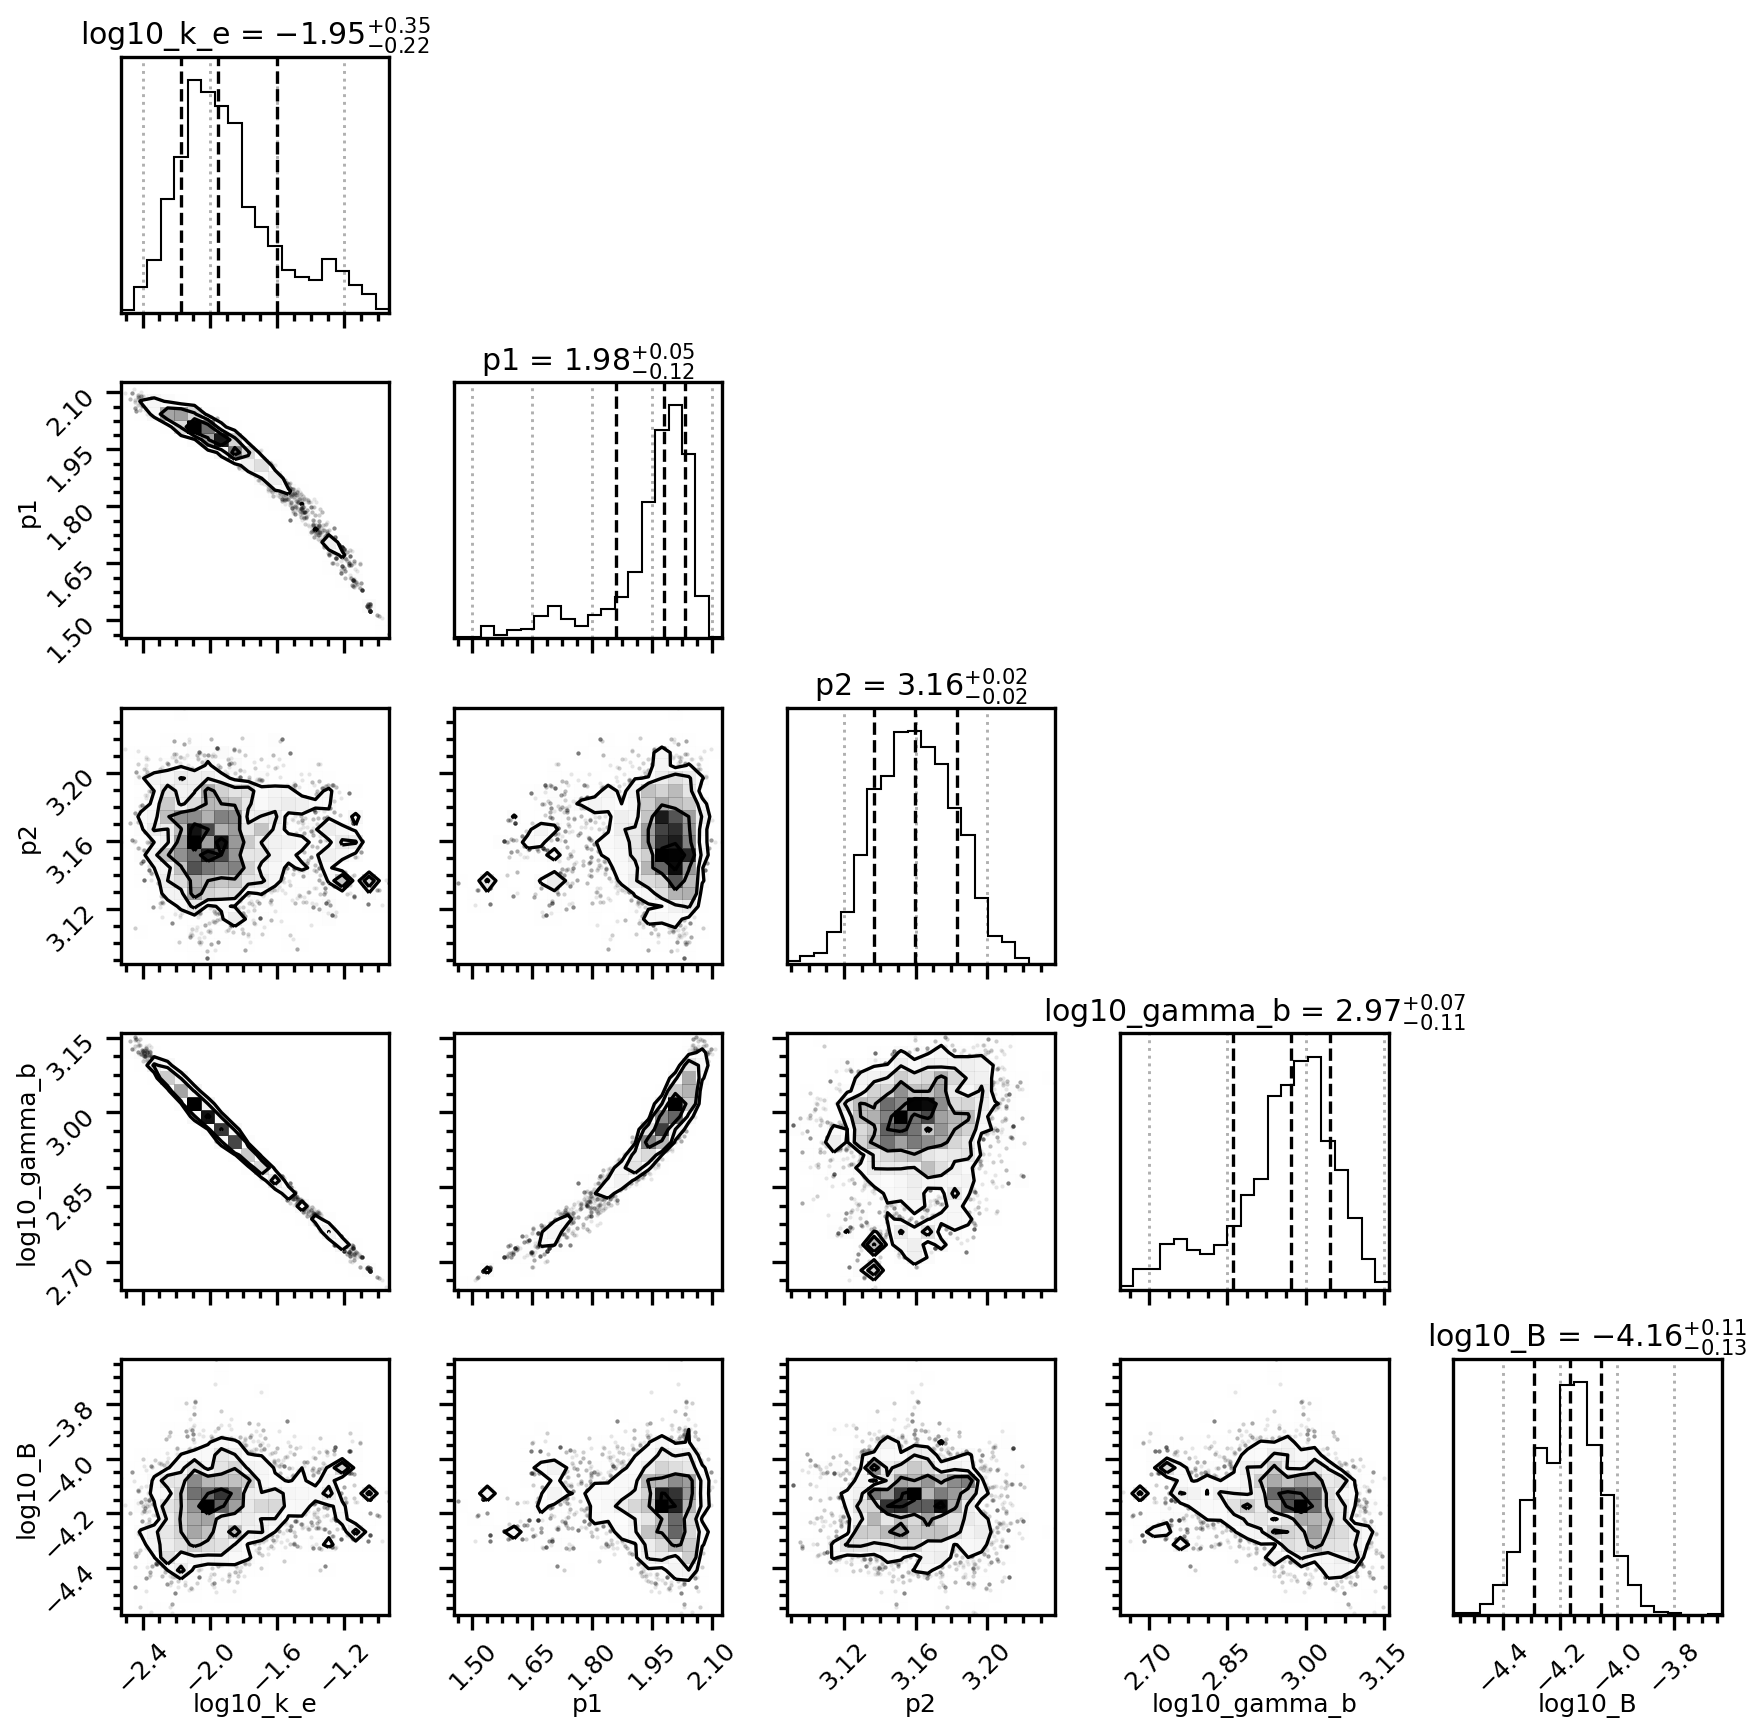

In [53]:
plot_corner(sampler, dataset_ec, nburn=100)

/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy

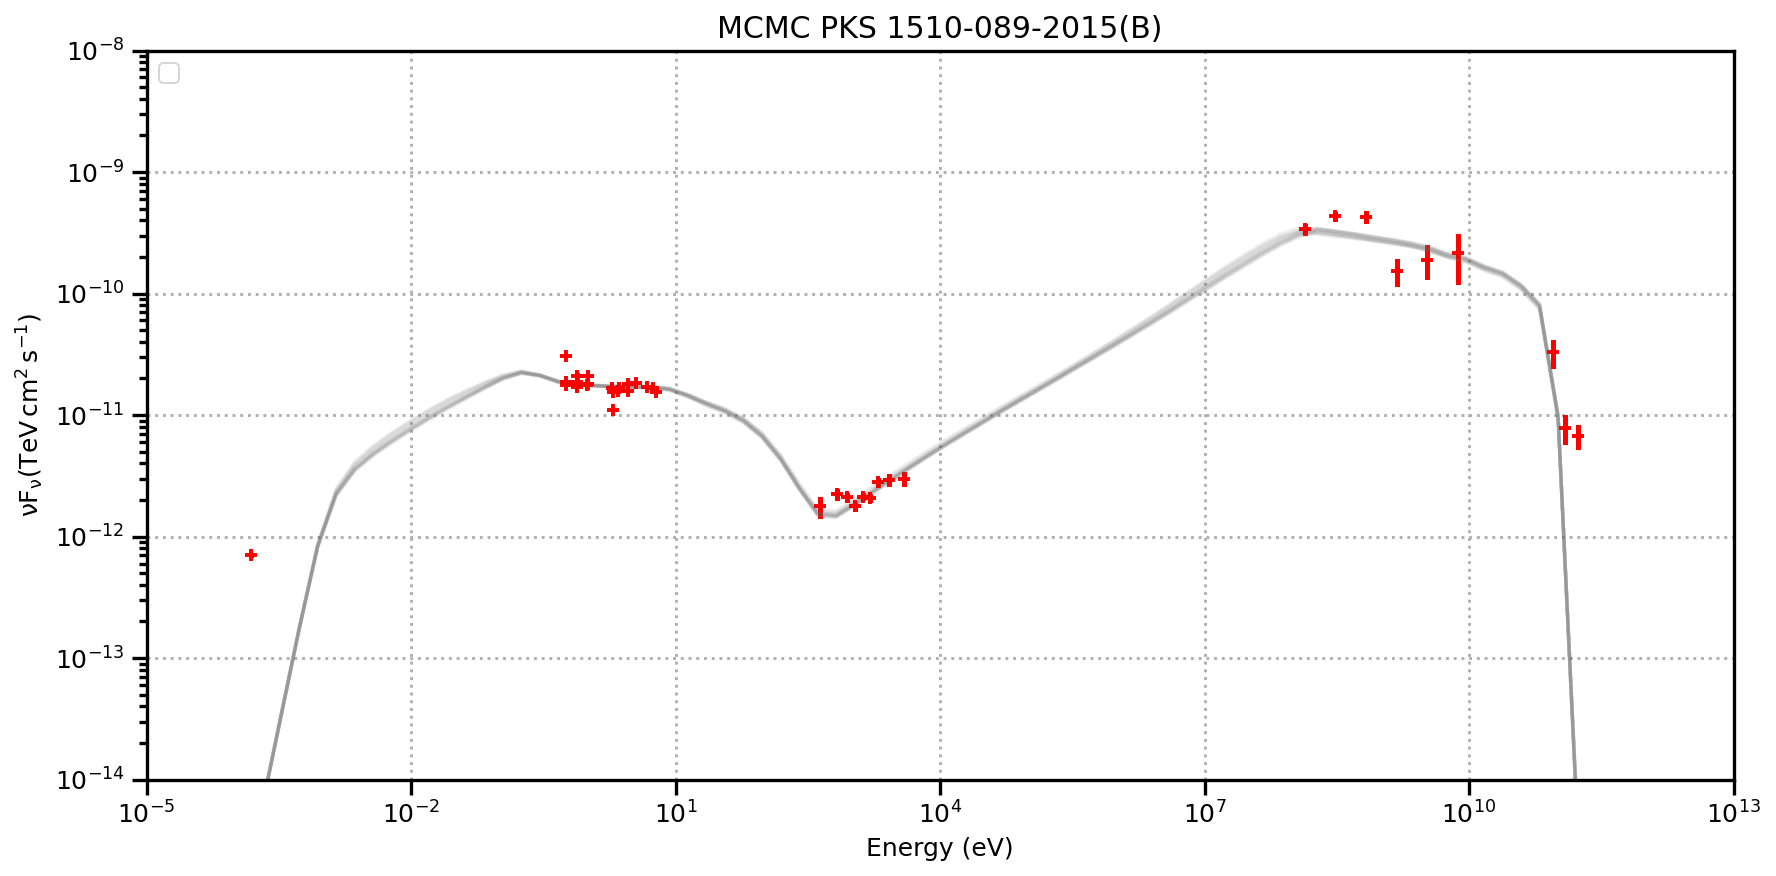

In [54]:
emin, emax = [1e-6, 1e15] * u.eV
nburn = 100

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.title('MCMC PKS 1510-089-2015(B)')

for nwalk in range(0, 6):
    for n in range(nburn, nburn + 10):
        pars = sampler.chain[nwalk, n, :]

        # set model parameters
        par_to_model(dataset_ec, pars)
        spectral_model = dataset_ec.models[0].spectral_model

        spectral_model.plot(
            energy_range=(emin, emax),
            ax=ax,
            energy_unit = "eV",
            energy_power=2,
            alpha=0.02,
            color="grey",  #how to mark each radiative process?
        )
        flux_points.plot(energy_unit="eV", energy_power=2 , color = 'red')
        plt.ylabel(r'$\rm{\nu F_\nu (TeV \, cm^2 \, s^{-1})}$')
        plt.ylim(1e-14,1e-8)
        plt.xlim(1e-5,1e13)
        plt.legend(loc = 2)


In [59]:
from IPython.display import display, Math

for i, par in enumerate(
    [
        "\log_{10}(k_{\mathrm e}\,/\,{\mathrm cm}^{-3})",
        "p_1",
        "p_2",
        "\log_{10}(\gamma_{\mathrm b})",
        "\log_{10}(B\,/\,{\mathrm G})",
    ]
):

    # the sampler.chain has shape (# walker, # steps, # parameters)
    par_values = sampler.chain[:, 100:, i].flatten()
    mcmc = np.quantile(par_values, [0.16, 0.50, 0.84])
    q = np.diff(mcmc)

    txt = "{3} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], par)
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [57]:
print(agnpy_ec.p1.error, agnpy_ec.log10_gamma_b.error,agnpy_ec.p2.error,agnpy_ec.log10_gamma_min.error,agnpy_ec.log10_gamma_max.error,agnpy_ec.log10_k_e.error)


0.02343167751454519 0.017976871496920028 0.029444951774199736 0.0 0.0 0.05369822212463883
